## Generate tactile stim STA videos
 * Show STA montage
 * Optionally, save TIFF stack of montage (to be converted to animated GIF)

Initialized with 91 trials.
Filtered to 1 trials.
Frame pre-stim: 4, Frame post-stim: 24


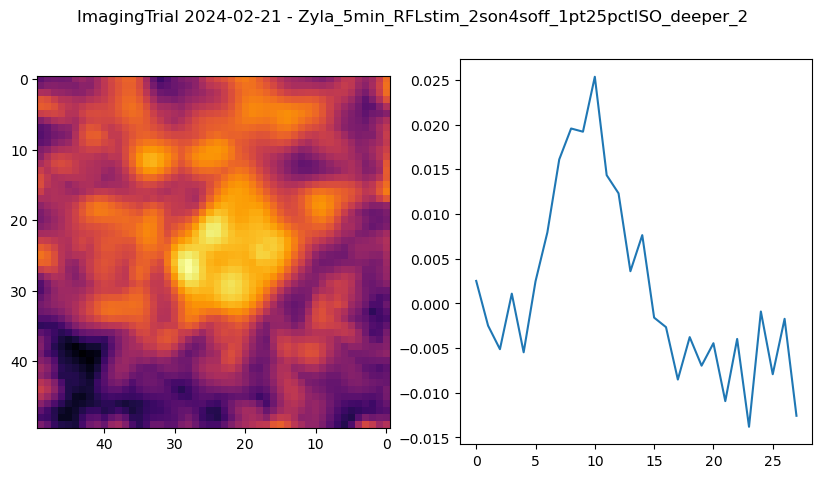

In [14]:
import os

import matplotlib.pyplot as plt
import numpy as np
from neuroprocessing.imagingtrials import ImagingTrialLoader
from skimage import io
from skimage.filters import gaussian
from skimage.util import montage

imaging_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
imaging_trials.filter(exp_dir='2024-02-21',# "2024-03-19",
limb='RFL',
rec_time='5min',
# remainder='.*pt25pctISO_2'
)

show_montage = False
flipLR = True # Flip image left/right because the camera image is flipped
sta_dir = 'rendered_STA'

# make dir to save rendered images
os.makedirs(sta_dir, exist_ok=True)

ssc_LHL_roi = {
    "center": (125,175),  # (x, y)
    "width": 80,
    "height": 80
}
ssc_RHL_roi = {
    "center": (265,175),  # (x, y)
    "width": 80,
    "height": 80
}
ssc_RFL_roi = {
    "center": (335,210),  # (x, y)
    "width": 50,
    "height": 50
}
for t in imaging_trials.trials:
  sta_df, dff = t.get_sta_stack(1,5,.5, ssc_RFL_roi) #ssc_roi
  
  sta_df = sta_df.mean(axis=0)
  n_plots = sta_df.shape[0]
  # add xy blur to sta_df image

  sta_df = gaussian(sta_df, sigma=2, channel_axis=0)


  if show_montage:
    f,ax = plt.subplots(1,1, figsize=(10,10))
    if flipLR:
      sta_df = np.flip(sta_df, axis=2)
    ax.imshow(montage(sta_df,
                      fill = 0,
                      padding_width = 20,
                      rescale_intensity=False,
                      grid_shape= None,
                      ),
            cmap='viridis',
            #vmin=30000,
            #vmax=40000
            )
    ax.axis('off')
    ax.set_title(t)
    # io.imsave(os.path.join(sta_dir, f'{t}_STA.tiff'), sta_df[1:,:,:].astype(np.uint16))
  else:
    f,axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(sta_df.max(axis=0), cmap='inferno')
    axs[1].plot(dff)
    if flipLR:
      axs[0].invert_xaxis()
    f.suptitle(t)


## Generate whole-brain injection traces

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuroprocessing.imagingtrials import ImagingTrialLoader

inj_trials = ImagingTrialLoader('/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections')
inj_trials.filter(exp_dir='2024-03-19',# "2024-03-19",
                  limb='(L|R)HL$',
                  # rec_time='15min',
                  # injection_type='.*inj'
                  # remainder='.*ISO_2'
)

# Plot the traces
fig, ax = plt.subplots(figsize=(5,3))
for inj_trial in inj_trials:
    t, trace = inj_trial.load_trace()
    trace = trace - trace[np.where(t >= 0)[0][0]]
    # remove slope
    trace = trace - np.polyval(np.polyfit(t, trace, 1), t)
    ax.plot(t, trace, label=inj_trial)
# legend to the right of the plot
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.axvline(x=0, color='r', linestyle='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Response (a.u.)')
# ax.set_xlim([-50, 600])



# SVD and alignment to AI CCF

In [ ]:
import glob
import os
import sys

import numpy as np
from neuroprocessing.scripts.analysis import _identify_trial_save_paths
from skimage import io
from wfield import (
        SVDStack,
        allen_load_reference,
        allen_transform_regions,
        approximate_svd,
        atlas_from_landmarks_file,
        chunk_indices,
        load_allen_landmarks,
        load_stack,
)


def _run_SVD(img_stack, n_SVD_components = 200):
    """ Wrapper for wfield's SVD function"""

    chunkidx = chunk_indices(len(img_stack),chunksize=256)
    _frame_averages = []
    for on,off in chunkidx:
        _frame_averages.append(img_stack[on:off].mean(axis=0))

    _frames_average = np.stack(_frame_averages).mean(axis = 0)
    U,SVT = approximate_svd(img_stack, _frames_average, 
                            k = n_SVD_components,
                            nframes_per_bin=10)
    return _frames_average, U,SVT

def _reconstruct(u,svt,dims = None):
    """Reconstruct the movie from the SVD components."""
    if dims is None:
            dims = u.shape[:2]
    return (u@svt).reshape((*dims,-1)).transpose(-1,0,1).squeeze()


def run_SVD_and_alignment(exp_dir, trial_dir, params):
    trial_path, save_path = _identify_trial_save_paths(exp_dir, trial_dir, params)
    dat = load_stack(save_path / (params["preprocess_prefix"] + trial_dir + ".tif"))

    frames_average, U,SVT = _run_SVD(dat, n_SVD_components = 2)

    # reconstructed movie
    mov = _reconstruct(U,SVT).reshape(dat.nframes,1,*U.shape[:2])
    mov = (mov*frames_average)+frames_average
    # save SVD
    np.save(save_path / ('U_' + params["process_prefix"] + trial_dir + '.npy'), U)
    np.save(save_path / ('SVT_' + params["process_prefix"] + trial_dir + '.npy'), SVT)
    np.save(save_path / ('frames_average_' + params["process_prefix"] + trial_dir + '.npy'), frames_average)
    io.imsave(save_path / ('svd_' + params["process_prefix"] + trial_dir + '.tif'), mov.squeeze().astype(np.uint16))

    from wfield.widgets import QApplication, RawViewer
    app_args = ['/Users/ilya_arcadia/miniconda3/envs/neuro/bin/wfield', 'open_raw', trial_path]
    app = QApplication(app_args)
    w = RawViewer(raw = dat,
                    mask = None,
                    folder = trial_path,
                    trial_onsets = None,
                    reference = 'dorsal_cortex')
    # close app
    app.exec_()

    del dat

    # AI CCF alignment
    landmarks_json = os.path.join(trial_path,'dorsal_cortex_landmarks.json')
    U = np.load(glob.glob(os.path.join(trial_path, 'U_*.npy'))[0])
    SVT = np.load(glob.glob(os.path.join(trial_path, 'SVT_*.npy'))[0])

    stack = SVDStack(U,SVT)
    lmarks = load_allen_landmarks(os.path.join(trial_path,'dorsal_cortex_landmarks.json'))

    ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
    # the reference is in allen CCF space and needs to be converted
    # this converts to warped image space (accounting for the transformation)
    ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                        resolution = lmarks['resolution'],
                                            bregma_offset = lmarks['bregma_offset'])
    atlas, areanames, brain_mask = atlas_from_landmarks_file(landmarks_json) # this loads the atlas in transformed coords

    # this does the transform (warps the original images)
    # stack.set_warped(1, M = lmarks['transform']) # this warps the spatial components in the stack
    stack.set_warped(False)
    return ccf_regions

params = {
        "downsample_factor": 8,
        "aligner_target_num_features": 700,
        "secs_before_stim": 60, # only process frames starting at X seconds before stimulus
        "preprocess_prefix": "aligned_downsampled_",
        "process_prefix": 'processed_',
        "s3fs_toplvl_path": "/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos",
        "local_toplvl_path": '/Users/ilya_arcadia/Neuroimaging_local/Processed/wfield_testing',
        "load_from_s3": False,
        "save_to_s3": False,
        'crop_px' : 20,
        'bottom_percentile' : 5
        }

ccf = run_SVD_and_alignment('2024-03-20-F1Num8REP', 'Zyla_15min_RHL_salineInj_1pt5pctISO_1',
                            params=params)


# Generate dorsal mask png using wfield

In [ ]:
import matplotlib.pyplot as plt

def plot_allen_regions(ax, ccf_regions,
                          resolution = 1,
                          bregma_offset = np.array([0,0]),
                          side_selection='both'):
    '''
    Plot the Allen CCF regions on a matplotlib axis.
    '''

    regs = []
    for p in ccf_regions.iterrows():
        c = p[1]
        if side_selection in ['right','both']:
            ax.plot(np.array(c.right_x)/resolution + bregma_offset[0],
                    np.array(c.right_y)/resolution + bregma_offset[1], 'w')
            # regs.append(hv.Curve(np.vstack([np.array(c.right_x)/resolution + bregma_offset[0],
            #                                 np.array(c.right_y)/resolution + bregma_offset[1]]).T))
        if side_selection in ['left','both']:
            ax.plot(np.array(c.left_x)/resolution + bregma_offset[0],
                    np.array(c.left_y)/resolution + bregma_offset[1], 'w')
            # regs.append(hv.Curve(np.vstack([np.array(c.left_x)/resolution + bregma_offset[0],
            #                                 np.array(c.left_y)/resolution + bregma_offset[1]]).T))
    # invert y axis
    return ax

img = io.imread('/Users/ilya_arcadia/Neuroimaging_local/Processed/wfield_testing/2024-03-20-F1Num8REP/Zyla_15min_RHL_salineInj_1pt5pctISO_1/aligned_downsampled_Zyla_15min_RHL_salineInj_1pt5pctISO_1.tif')
img_max = img.max(axis=0)
del img
f, ax = plt.subplots()
# ax.imshow(img_max, cmap='gray')
plot_allen_regions(ax, ccf, resolution = 1, bregma_offset = np.array([0,0]), side_selection='both')
ax.set_axis_off()
f.savefig('test.png')

# Quick script to calculate FFT of signal

In [ ]:
## FFT of the ROI
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

# get roi at center of image
center = np.array(img.shape) // 2
roi = img[:,center[1]-50:center[1]+50, center[2]-50:center[2]+50]
roi_mean = np.mean(roi, axis=(1,2))
# calculate heart rate using FFT

fs = 10 # Hz
t_orig = np.arange(0, len(roi_mean)) / fs
roi_mean = roi_mean - np.mean(roi_mean)
N = len(roi_mean)
yf = fft(roi_mean)
yf = 2.0/N * np.abs(yf[0:N//2])

xf = fftfreq(N, 1/fs)[:N//2]
f, axs = plt.subplots(2, 1)
axs[0].plot(roi_mean)
axs[0].set_xlim(0, 200)
axs[1].plot(xf, yf)
plt.xlim(0.5,3)
plt.ylim(0, 3)

# find peaks
peaks, _ = find_peaks(yf, height=5, distance=10)
plt.plot(xf[peaks], yf[peaks], "x")

# Spectrogram figure

In [ ]:
import skimage.io as io
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks, spectrogram


def compute_breathing_rate(signal: np.array, fs:float) -> np.array:
    """Compute breathing rate from signal using spectrogram.
    Args:
        signal (np.ndarray): 1D array of signal
        fs (float): sampling frequency
    
    Returns:
        np.array: 1D numpy array of breathing rate, interpolated to be the same length as signal
    """

    min_peak_height = 100 # minimum height of freq peak in spectrogram
    min_breathing_freq, max_breathing_freq = 0.5, 2 # frequency range to look for breathing rate (Hz)
    spectrogram_nperseg = 200 # number of samples per segment in spectrogram
    spectrogram_noverlap = 50 # number of samples to overlap between segments in spectrogram


    f, t, Sxx = spectrogram(signal, fs, nperseg=spectrogram_nperseg,
                            noverlap=spectrogram_noverlap,
                            detrend = 'linear')
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylim(0, 3)


    breathing_freqs = (f > min_breathing_freq) & (f < max_breathing_freq)
    Sxx_breathing = Sxx[breathing_freqs]

    # find peaks in spectrogram
    f_peak_array = []
    for i in range(Sxx_breathing.shape[1]):
        peaks, _ = find_peaks(Sxx_breathing[:,i], height=min_peak_height, distance=4)
        # if >1 peak, keep only highest
        if len(peaks) > 0:
            peaks = [peaks[np.argmax(Sxx_breathing[peaks, i])]]
            f_peak = f[breathing_freqs][peaks]
            f_peak_array.append(f_peak[0])
        else:
            f_peak_array.append(np.nan)

    f_peak_array = np.array(f_peak_array)

    # remove nans
    t_peak_array = t[~np.isnan(f_peak_array)]
    f_peak_array = f_peak_array[~np.isnan(f_peak_array)]
    # plt.plot(t_peak_array,f_peak_array)

    # interpolate back to be the same size as roi_mean
    f_peak_interp = CubicSpline(t_peak_array, f_peak_array, bc_type='natural')

    return f_peak_interp(np.arange(0, len(signal)) / fs)

if 'img' not in locals():
    img = io.imread('/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos/2024-03-06/Zyla_15min_RHL_salineinj_1pt25pctISO_1/Zyla_15min_RHL_salineinj_1pt25pctISO_1_MMStack_Pos0.ome.tif')
center = np.array(img.shape) // 2
roi = img[:,center[1]-50:center[1]+50, center[2]-50:center[2]+50]
roi_mean = np.mean(roi, axis=(1,2))
f_breathing = compute_breathing_rate(roi_mean, fs = 10)
# f,ax = plt.subplots()
# plt.plot(f_breathing)

# Plot of FOV vs resolution for different microscopes at Arcadia

In [ ]:
import matplotlib.pyplot as plt

fovs = [13.7, 1, 10880, 151]
res = [615, 2300, 11, 190]
labels = ['Hina 4x', 'Hina 10x', 'Phenotypomat', 'UWFM']
f,ax = plt.subplots(figsize=(3,3))
plt.loglog(fovs,res, 'o')
plt.ylabel('Resolution (px/mm)')
plt.xlabel(r'Field of view $(mm{^2})$')
# add labels
for i, txt in enumerate(labels):
    if txt.startswith('Phe'):
        ax.annotate(txt, (fovs[i], res[i]), textcoords="offset points", xytext=(-5,0), va='center',
                    ha='right')
    else:
        ax.annotate(txt, (fovs[i], res[i]), textcoords="offset points", xytext=(10,0), va='center')
